In [1]:
import pandas as pd
import pyodbc
import joblib
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

### Get Data From SQL Server

In [2]:
# #Using pyodbc to connect to SQL server
# #username:password@host:port/database
# server = 'localhost'
# port = '1401'
# database = 'credit_risk_modeling' 
# username = 'SA' 
# password = ''  
# driver = 'ODBC+Driver+18+for+SQL+Server' #'/usr/local/lib/libmsodbcsql.18.dylib'
# # cnxn = pyodbc.connect('DRIVER={ODBC Driver 18 for SQL Server};SERVER='+server+','+port+';DATABASE='+database+';UID='+username+';PWD='+ password +';TrustServerCertificate=yes')
# # cursor = cnxn.cursor()

# #Using sqlalchemy to connect to SQL server
# conn_string = 'mssql+pyodbc://'+ username + ':' + password + '@' + server + ':' + port + '/' + database + '?driver=' + driver + '&TrustServerCertificate=yes'
# print(conn_string)
# cnxn = create_engine(conn_string) 
# df_original = pd.read_sql('SELECT * FROM credit_risk_dataset',cnxn)
# df_original = pd.read_csv('credit_risk_dataset.csv')


### Get data from csv File

In [3]:
df_original = pd.read_csv('credit_risk_dataset.csv')

In [4]:
df_original.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


11 features and 1 target variable


In [5]:

print(list(df_original.columns))
print(len(list(df_original.columns)))
df_original.head()

['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
12


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Null values:
- person_emp_length
- loan_int_rate

In [6]:
df_original.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

outliers present in:
- person_income
- person_age
- person_emp_length. 

In [7]:
df_original.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [8]:
df = df_original.copy()
df = df[['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 
         'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
         'cb_person_default_on_file', 'cb_person_cred_hist_length','loan_status']]


### Variables

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_default_on_file   32581 non-null  object 
 10  cb_person_cred_hist_length  32581 non-null  int64  
 11  loan_status                 32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [10]:
quant = ['person_age', 'person_income','person_emp_length',
         'loan_amnt', 'loan_int_rate','loan_percent_income','cb_person_cred_hist_length' ]
qual = ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file','loan_status']

In [11]:
for x in qual:
    df[x] = df[x].astype('category')

### Pair plots

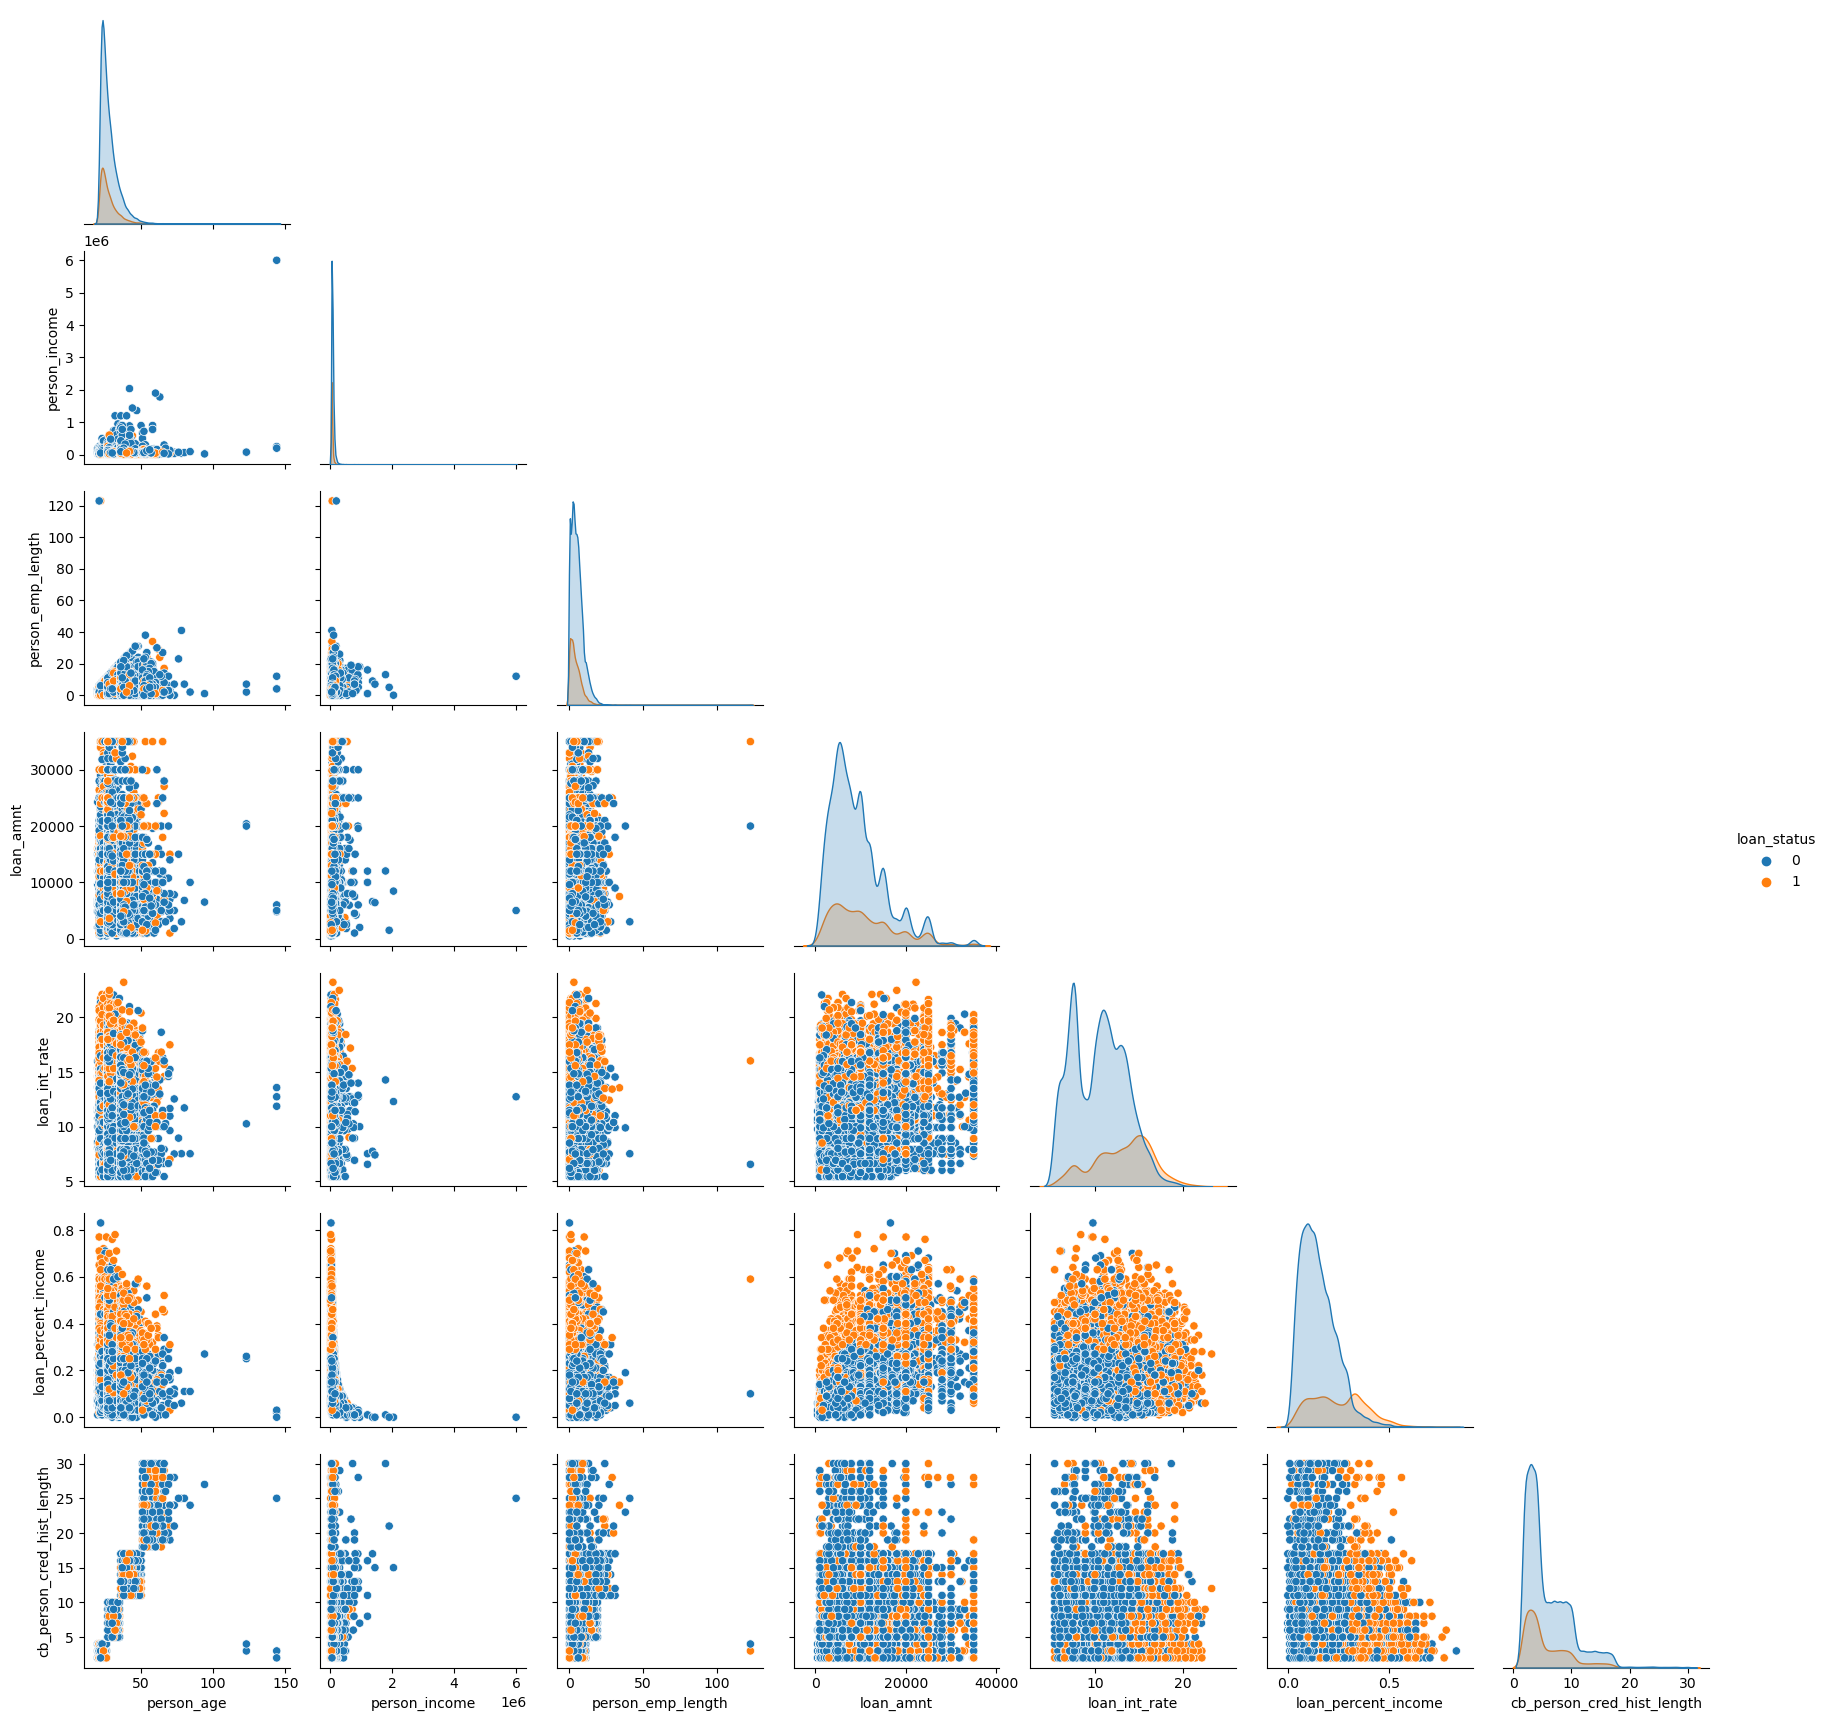

In [12]:
sns.pairplot(df,hue="loan_status",corner=True);
plt.show()

### Heat map

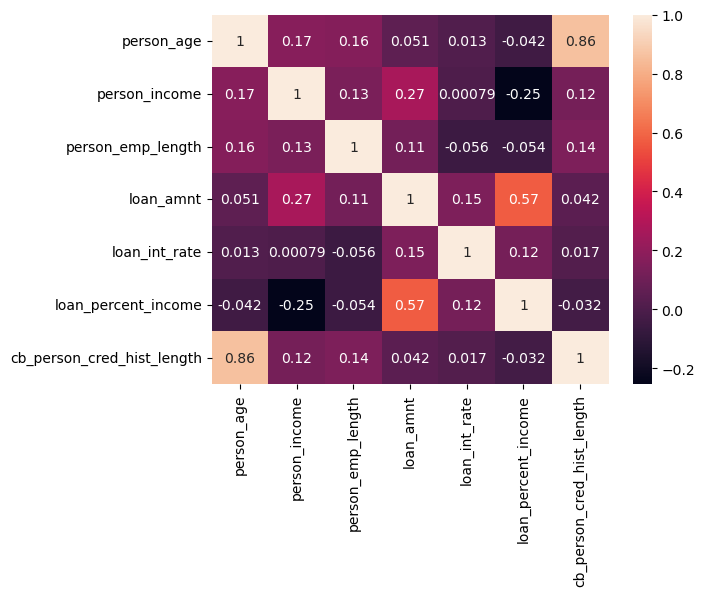

In [13]:
sns.heatmap(df[quant].corr(), annot=True);

### Distribution of quantitative variables

age, income and emp_length have outliers and have skewed distributions

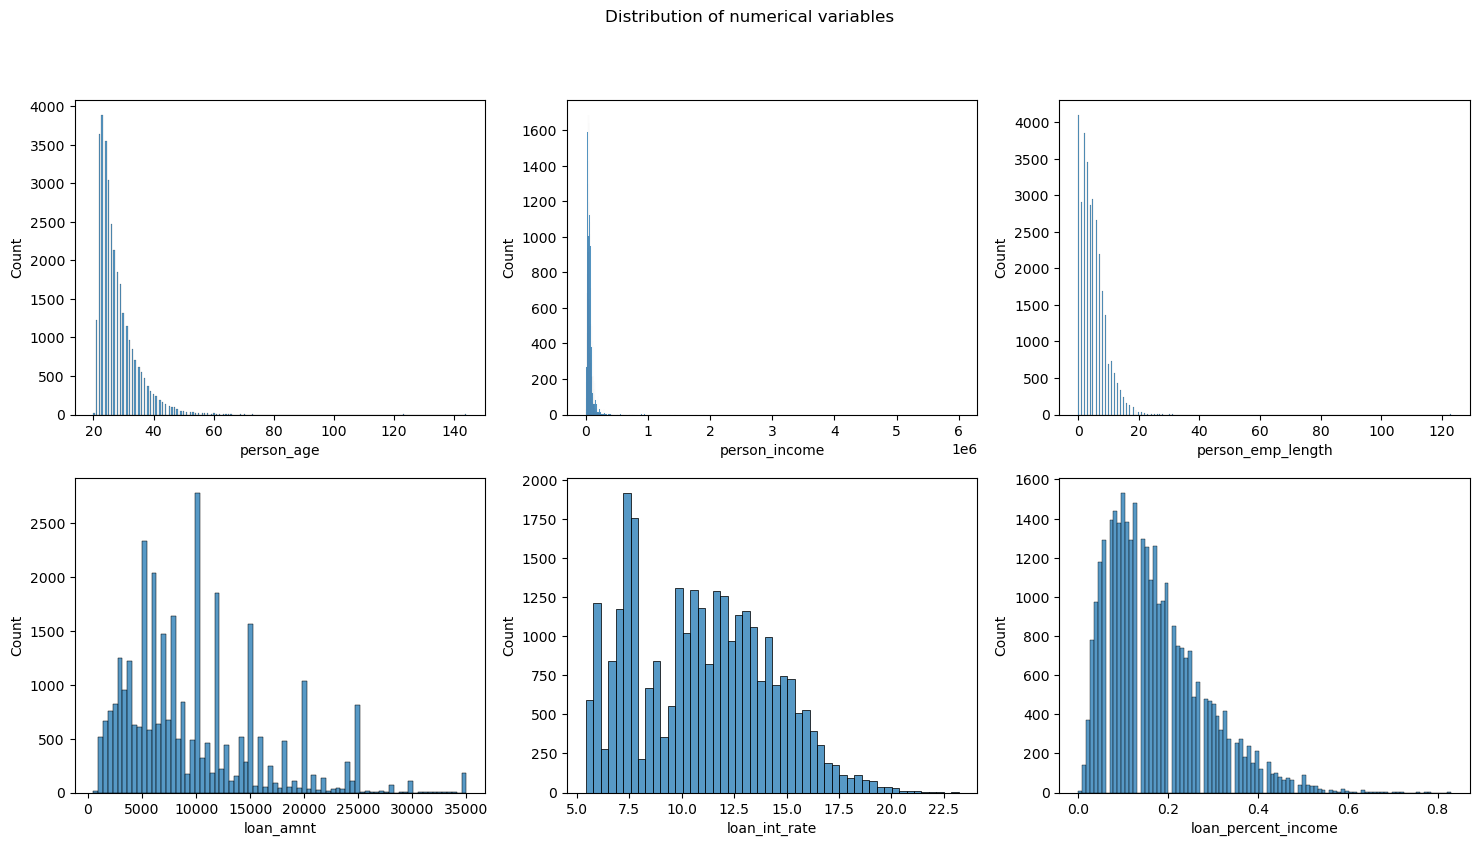

In [14]:
fig, axes = plt.subplots(2,3,figsize=(18,9))
fig.suptitle('Distribution of numerical variables')

for var,axe in zip(quant,list(axes.flatten())):
    sns.histplot(x=df[var],ax=axe)


In [15]:
age_threshold = 100
income_threshold = 1000000
emp_length_threshold = 50
print('Percentage of records removed')
print('Person\'s age - with a thresold of ',age_threshold,' :', 100*df[df['person_age']>age_threshold].shape[0]/df.shape[0], '%. Count (rows): ',df[df['person_age']>age_threshold].shape[0])
print('Person\'s income - with a thresold of ',income_threshold,' :', 100*df[df['person_income']>income_threshold].shape[0]/df.shape[0], '%. Count (rows): ',df[df['person_income']>income_threshold].shape[0])


Percentage of records removed
Person's age - with a thresold of  100  : 0.015346367514809245 %. Count (rows):  5
Person's income - with a thresold of  1000000  : 0.02762346152665664 %. Count (rows):  9


In [16]:
print('Thresholding age:')
before = df.shape[0]
print('Total Number of rows before: ', before)
df = df[df['person_age']<age_threshold]
print('Total Number of rows: ', df.shape[0])
print('Rows removed: ', before - df.shape[0])

Thresholding age:
Total Number of rows before:  32581
Total Number of rows:  32576
Rows removed:  5


In [17]:
print('Thresholding income:')
before = df.shape[0]
print('Total Number of rows before: ', before)
df = df[df['person_income']<income_threshold]
print('Total Number of rows: ', df.shape[0])
print('Rows removed: ', before - df.shape[0])

Thresholding income:
Total Number of rows before:  32576
Total Number of rows:  32568
Rows removed:  8


In [18]:

print('Thresholding employment length:')
before = df.shape[0]
print('Total Number of rows before: ', before)
df = df[(df['person_emp_length']<emp_length_threshold)|(df['person_emp_length'].isna()) ]
print('Total Number of rows after: ', df.shape[0])
print('Rows removed: ', before - df.shape[0])


Thresholding employment length:
Total Number of rows before:  32568
Total Number of rows after:  32566
Rows removed:  2


Imbalanced dataset. 20% people defaulted

In [19]:
df.loan_status.value_counts(1)

0    0.781766
1    0.218234
Name: loan_status, dtype: float64

Relationship between loan grade, loan income and loan status.
- people who defaulted have higher loan to income ratio on average
- People from loan grade G were never able to pay back their loans

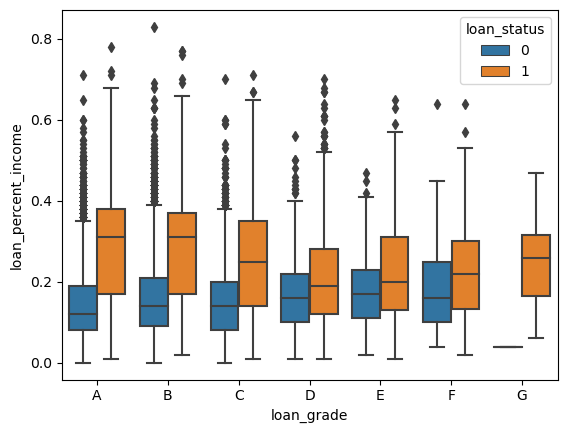

In [20]:
sns.boxplot(data=df, x="loan_grade", y="loan_percent_income", hue="loan_status");

### Machine Learning pipeline

In [21]:
target = df.loan_status                 
features = df.drop(['loan_status'], axis=1) 
X_train, X_valid, y_train, y_valid = train_test_split(features, target, train_size=0.8, test_size=0.2, random_state=0)

In [22]:
qual.remove('loan_status')

In [23]:
print(quant)
print(qual)

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [24]:
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=
                                   [('impute', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=
                                [('numerical', numerical_transformer, quant),
                                 ('categorical', categorical_transformer, qual )])

In [25]:
bst = XGBClassifier()

In [26]:
risk_modeling_pipeline = Pipeline(steps=
                                 [('preprocess', preprocessor),
                                  ('model', bst)])
risk_modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numerical', SimpleImputer(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('categorical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore...
           

In [27]:
predictions = risk_modeling_pipeline.predict(X_valid)

print(metrics.classification_report(y_valid, predictions))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5115
           1       0.96      0.73      0.83      1399

    accuracy                           0.93      6514
   macro avg       0.94      0.86      0.89      6514
weighted avg       0.94      0.93      0.93      6514



In [28]:
output = pd.DataFrame({'Id': X_valid.index,
                     'Loan Status': predictions})
output.head()

,Id,Loan Status
0,14338,0
1,29636,0
2,21088,0
3,8034,0
4,15082,0


In [29]:
joblib.dump(risk_modeling_pipeline, 'risk_modeling_pipeline.pkl')

['risk_modeling_pipeline.pkl']